# 1. Importação das bilbiotecas necessárias



In [1]:
# Importando o pandas
import pandas as pd

# Importando biblioteca para trabalhar com o MongoDB
import pymongo as pym

# Importando o numpy para trabalhar com cálculos matemáticos
import numpy as np

#Importando o seaborn e o matplotlib para análises gráficas
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Carga do arquivo e dados iniciais

In [2]:
# Lendo o arquivo CSV disponível nos microdados do Censo da Educação Superior e gravando
# ele em um DataFrame
ies = pd.read_csv('../data/SUP_IES_2019.CSV', sep="|", encoding="latin-1")

In [3]:
# Mostrando a quantidade de linhas e colunas do DataFrame 
print("Quantidade de linhas:",ies.shape[0])
print("Quantidade de colunas:",ies.shape[1])

Quantidade de linhas: 2608
Quantidade de colunas: 48


In [4]:
# Verificando as 5 primeiras linhas do arquivo
ies.head()

,NU_ANO_CENSO,CO_IES,NO_IES,SG_IES,CO_MANTENEDORA,NO_MANTENEDORA,TP_CATEGORIA_ADMINISTRATIVA,TP_ORGANIZACAO_ACADEMICA,CO_REGIAO,CO_UF,...,VL_RECEITA_PROPRIA,VL_RECEITA_TRANSFERENCIA,VL_RECEITA_OUTRA,VL_DESPESA_PESSOAL_DOCENTE,VL_DESPESA_PESSOAL_TECNICO,VL_DESPESA_PESSOAL_ENCARGO,VL_DESPESA_CUSTEIO,VL_DESPESA_INVESTIMENTO,VL_DESPESA_PESQUISA,VL_DESPESA_OUTRA
0,2019,1,UNIVERSIDADE FEDERAL DE MATO GROSSO,UFMT,1,FUNDACAO UNIVERSIDADE FEDERAL DE MATO GROSSO,1,1,5,51,...,8075408.31,9.190156e+08,0.00,2.737906e+08,1.089490e+08,1.050124e+08,1.225790e+08,9606414.13,2512494.15,3.046410e+08
1,2019,2,UNIVERSIDADE DE BRASÍLIA,UNB,2,FUNDACAO UNIVERSIDADE DE BRASILIA,1,1,5,53,...,42309485.04,6.376632e+07,53681013.45,8.438613e+08,0.000000e+00,2.873756e+08,2.102659e+08,23154904.42,10350582.30,4.738549e+08
2,2019,3,UNIVERSIDADE FEDERAL DE SERGIPE,UFS,3,FUNDACAO UNIVERSIDADE FEDERAL DE SERGIPE,1,1,2,28,...,2064512.28,8.836851e+08,59978137.27,2.847694e+08,1.533374e+08,1.080347e+08,1.491604e+08,8212361.64,1445146.30,3.204186e+08
3,2019,4,UNIVERSIDADE FEDERAL DO AMAZONAS,UFAM,4,FUNDACAO UNIVERSIDADE DO AMAZONAS,1,1,1,13,...,5603181.06,1.063315e+09,1721653.86,4.482062e+08,0.000000e+00,1.322010e+08,1.839712e+08,12676251.59,1312837.53,6.845330e+07
4,2019,6,UNIVERSIDADE FEDERAL DE OURO PRETO,UFOP,6,UNIVERSIDADE FEDERAL DE OURO PRETO,1,1,3,31,...,5905654.74,4.992185e+08,30461740.62,1.691617e+08,5.899877e+07,4.092087e+07,4.907550e+07,73345.77,828200.00,2.165275e+08


In [5]:
# Importando arquivo de cidades do IBGE que servirá para popular o endereço das IES
colunas = ['codigo_ibge','NO_MUNICIPIO','LAT_MUNICIPIO','LON_MUNICIPIO','CO_UF','SG_UF','NO_UF']
municipios = pd.read_csv('../data/municipios.csv', sep=",", header=0, names=colunas)

In [6]:
municipios.shape

(5570, 7)

In [7]:
municipios.head(3)

,codigo_ibge,NO_MUNICIPIO,LAT_MUNICIPIO,LON_MUNICIPIO,CO_UF,SG_UF,NO_UF
0,5200050,Abadia de Goiás,-16.7573,-49.4412,52,GO,Goiás
1,3100104,Abadia dos Dourados,-18.4831,-47.3916,31,MG,Minas Gerais
2,5200100,Abadiânia,-16197.0000,-48.7057,52,GO,Goiás


In [8]:
# Removendo colunas desnecessárias
municipios.drop(['CO_UF'], axis=1, inplace = True)

In [9]:
municipios.dtypes

codigo_ibge        int64
NO_MUNICIPIO      object
LAT_MUNICIPIO    float64
LON_MUNICIPIO    float64
SG_UF             object
NO_UF             object
dtype: object

# 3 Tratando os dados do dataset

In [12]:
# Criando um DataFrame somente com as colunas de endereço das IES 
# E outro com as colunas consideradas na estrutura do trabalho
endereco_ies = ies[{'CO_REGIAO','CO_UF','CO_MUNICIPIO','IN_CAPITAL'}]

ies = ies[{'CO_IES','NO_IES','SG_IES',
           'TP_CATEGORIA_ADMINISTRATIVA',
           'TP_ORGANIZACAO_ACADEMICA','QT_TEC_TOTAL'}]

In [14]:
# Adicionando uma coluna Endereco no DataFrame das IES, pois por padrão
# essa coluna não existe
ies['ENDERECO'] = ""

In [15]:
endereco_ies.dtypes

CO_MUNICIPIO    int64
IN_CAPITAL      int64
CO_REGIAO       int64
CO_UF           int64
dtype: object

In [16]:
## Categorizando o IN_CAPITAL do endereco 
# 1) Alterando o tipo dos dados int, para object (string)
endereco_ies['IN_CAPITAL'] = endereco_ies['IN_CAPITAL'].apply(str)

In [17]:
# Alterando os valores por suas respectivas categorias  
# 2) IN CAPITAL 0: Não; 1: Sim. 
endereco_ies.loc[endereco_ies['IN_CAPITAL'] == '0', 'IN_CAPITAL'] = 'Não'
endereco_ies.loc[endereco_ies['IN_CAPITAL'] == '1', 'IN_CAPITAL'] = 'Sim'

In [18]:
# fazendo um merge de endereço com municipios
endereco_ies = endereco_ies.merge(municipios, how='left', left_on='CO_MUNICIPIO', right_on='codigo_ibge')

In [19]:
endereco_ies.shape

(2608, 10)

In [20]:
# Removendo colunas desnecessárias
endereco_ies.drop(['codigo_ibge'], axis=1, inplace = True)

In [21]:
# Resultado da junção de endereço e municipios
endereco_ies.head(3)

,CO_MUNICIPIO,IN_CAPITAL,CO_REGIAO,CO_UF,NO_MUNICIPIO,LAT_MUNICIPIO,LON_MUNICIPIO,SG_UF,NO_UF
0,5103403,Sim,5,51,Cuiabá,-15601.0000,-56.0974,MT,Mato Grosso
1,5300108,Sim,5,53,Brasília,-15.7795,-47.9297,DF,Distrito Federal
2,2806701,Não,2,28,São Cristóvão,-11.0084,-37.2044,SE,Sergipe


In [22]:
endereco_ies.isnull().sum()

CO_MUNICIPIO     0
IN_CAPITAL       0
CO_REGIAO        0
CO_UF            0
NO_MUNICIPIO     0
LAT_MUNICIPIO    0
LON_MUNICIPIO    0
SG_UF            0
NO_UF            0
dtype: int64

In [23]:
endereco_ies.shape

(2608, 9)

In [24]:
# Criando um dicionário do Python a partir do DataFrame de enderecos
endereco_ies_dict = endereco_ies.to_dict('records')

In [25]:
endereco_ies_dict[200]

{'CO_MUNICIPIO': 4311403,
 'IN_CAPITAL': 'Não',
 'CO_REGIAO': 4,
 'CO_UF': 43,
 'NO_MUNICIPIO': 'Lajeado',
 'LAT_MUNICIPIO': -29.4591,
 'LON_MUNICIPIO': -51.9644,
 'SG_UF': 'RS',
 'NO_UF': 'Rio Grande do Sul'}

In [26]:
# Adicionando um endereco (através do dicionário criado no passo anterior)
# e inserindo na coluna "ENDERECO" de cada IES
for i in ies.index:
    ies.at[i,'ENDERECO'] = endereco_ies_dict[i]  

In [27]:
print(ies.query("SG_IES == 'UNIVATES'")['ENDERECO'])

200    {'CO_MUNICIPIO': 4311403, 'IN_CAPITAL': 'Não',...
Name: ENDERECO, dtype: object


In [28]:
ies.isnull().sum()

NO_IES                           0
TP_ORGANIZACAO_ACADEMICA         0
QT_TEC_TOTAL                     0
TP_CATEGORIA_ADMINISTRATIVA      0
CO_IES                           0
SG_IES                         464
ENDERECO                         0
dtype: int64

In [29]:
# Alterando os valores nulos da sigla da IES para 'Sem sigla'.
ies['SG_IES'].fillna('Sem SIGLA', inplace = True)

In [30]:
# 1) Alterando o tipo dos dados int, para object (string)
ies['TP_CATEGORIA_ADMINISTRATIVA'] = ies['TP_CATEGORIA_ADMINISTRATIVA'].apply(str)
ies['TP_ORGANIZACAO_ACADEMICA'] = ies['TP_ORGANIZACAO_ACADEMICA'].apply(str)


In [31]:
# Alterando os valores por suas respectivas categorias  
# 2) TP_CATEGORIA_ADMINISTRATIVA: 1: Pública Federal; 2: Pública Federal; 
# 3: Pùblica Municipal; 4: Privada com fins lucrativos; 5: Privada sem fins lucrativos;
# 6: Privada - Particular em sentido estrito; 7: Especial
# 8: Privada comunitária; 9: Privada confessional.  
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '1', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Pública Federal'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '2', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Pública Federal'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '3', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Pública Municipal'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '4', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Privada com fins lucrativo'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '5', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Privada sem fins lucrativos'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '6', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Privada - Particular em sentido estrito'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '7', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Especial'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '8', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Privada comunitária'
ies.loc[ies['TP_CATEGORIA_ADMINISTRATIVA'] == '9', 'TP_CATEGORIA_ADMINISTRATIVA'] = 'Privada confessional'

# 2) TP_ORGANIZACAO_ACADEMICA: 1: Universidade; 2: Centro Universitário; 
# 3: Faculdade; 4: Instituto Federal de Educação Ciência e Tecnologia; 
# 5: Centro Federal de Educação Tecnológica
  
ies.loc[ies['TP_ORGANIZACAO_ACADEMICA'] == '1', 'TP_ORGANIZACAO_ACADEMICA'] = 'Universidade'
ies.loc[ies['TP_ORGANIZACAO_ACADEMICA'] == '2', 'TP_ORGANIZACAO_ACADEMICA'] = 'Centro Universitário'
ies.loc[ies['TP_ORGANIZACAO_ACADEMICA'] == '3', 'TP_ORGANIZACAO_ACADEMICA'] = 'Faculdade'
ies.loc[ies['TP_ORGANIZACAO_ACADEMICA'] == '4', 'TP_ORGANIZACAO_ACADEMICA'] = 'Instituto Federal de Educação Ciência e Tecnologia'
ies.loc[ies['TP_ORGANIZACAO_ACADEMICA'] == '5', 'TP_ORGANIZACAO_ACADEMICA'] = 'Centro Federal de Educação Tecnológica'


In [32]:
ies.head(3)

,NO_IES,TP_ORGANIZACAO_ACADEMICA,QT_TEC_TOTAL,TP_CATEGORIA_ADMINISTRATIVA,CO_IES,SG_IES,ENDERECO
0,UNIVERSIDADE FEDERAL DE MATO GROSSO,Universidade,1483,Pública Federal,1,UFMT,"{'CO_MUNICIPIO': 5103403, 'IN_CAPITAL': 'Sim',..."
1,UNIVERSIDADE DE BRASÍLIA,Universidade,3233,Pública Federal,2,UNB,"{'CO_MUNICIPIO': 5300108, 'IN_CAPITAL': 'Sim',..."
2,UNIVERSIDADE FEDERAL DE SERGIPE,Universidade,1444,Pública Federal,3,UFS,"{'CO_MUNICIPIO': 2806701, 'IN_CAPITAL': 'Não',..."


# 4. Análise dos dados das ies


In [33]:
print("Quantidade de linhas: ", ies.shape[0])
print("Quantidade de colunas: ",ies.shape[1])

Quantidade de linhas:  2608
Quantidade de colunas:  7


In [34]:
ies.describe()

,QT_TEC_TOTAL,CO_IES
count,2608.000000,2608.000000
mean,145.374617,6872.965874
std,436.506763,7545.457622
min,1.000000,1.000000
25%,12.000000,1373.750000
50%,29.000000,2857.000000
75%,83.000000,14161.250000
max,9421.000000,24672.000000


Quantidade de ies por categoria administrativa


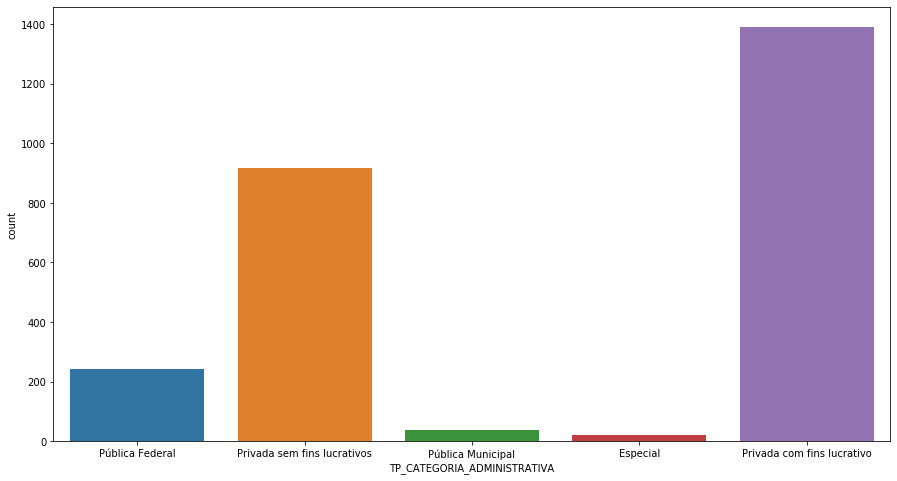

In [35]:
print("Quantidade de ies por categoria administrativa")
plt.figure(figsize=(15,8))
sns.countplot(x='TP_CATEGORIA_ADMINISTRATIVA', data=ies)

Quantidade de ies por organização acadêmica


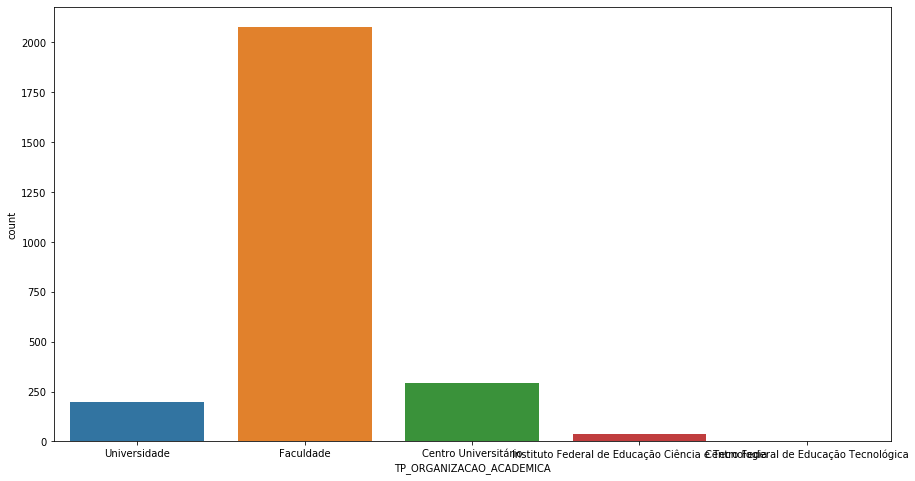

In [36]:
print("Quantidade de ies por organização acadêmica")
plt.figure(figsize=(15,8))
sns.countplot(x='TP_ORGANIZACAO_ACADEMICA', data=ies)

# 5. Envio dos dados para o mongoDB

In [37]:
# Criando a conexão com o mongoDB
client = pym.MongoClient('mongodb://localhost:27017/')

# Acessando a base de dados criada para o teste
db = client['censo']

# Acessando a coleção de teste "ies" criada 
collection_ies =  db['ies']

In [38]:
# Transformando o DataSet das IES em um dicionario com o objetivo
# de salvar ele no MongoDB, pois o banco não aceita estruturas do tipo DataFrame
ies_dict = ies.to_dict('records')

In [39]:
# Enviando os dados para o MongoDB
collection_ies.insert_many(ies_dict)